# Task 2 Multiclass classification Baseline

In this class, we will develop a baseline for Task 2 using the chess dataset. We will model the task as an multiclass classification task.

In [1]:
import matplotlib.pyplot as plt, numpy as np, os, torch, random, cv2, json
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torchvision import models
from torchvision.transforms import v2 as transforms
from sklearn.metrics import accuracy_score
from tqdm import tqdm

random.seed(42)

/opt/anaconda3/envs/tfenv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Connect Colab to Drive (if the dataset is on drive)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!unzip "drive/MyDrive/Dataset/images.zip" -d "."
!cp "drive/MyDrive/Dataset/annotations.json" -d "."

## Load dataset

**Tip**: since the images are very big, resize the dataset before loading it to save time and memory during training (use cubic interpolation to preserve image quality when downsizing the images)!

In [2]:
from torchvision.transforms import InterpolationMode
# Normalize images
data_aug = transforms.Compose([
    transforms.ToImage(),
    transforms.Resize((256, 256), interpolation=InterpolationMode.BICUBIC),
    transforms.CenterCrop((224, 224)),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_in = transforms.Compose([
    transforms.ToImage(),
    transforms.Resize((256, 256), interpolation=InterpolationMode.BICUBIC),
    transforms.CenterCrop((224, 224)),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [15]:
def chesspos2number(chesspos):
    col = ord(chesspos[0])-ord('a')
    row = int(chesspos[1])-1
    return row, col

class ChessDataset(Dataset):
    def __init__(self, root_dir, partition, transform=None):
        self.anns = json.load(open(os.path.join(root_dir, 'annotations.json')))
        self.categories = [c['name'] for c in self.anns['categories']]
        self.root = root_dir
        self.ids = []
        self.file_names = []
        for x in self.anns['images']:
            self.file_names.append(x['path'])
            self.ids.append(x['id'])
        self.file_names = np.asarray(self.file_names)
        self.ids = np.asarray(self.ids)
        self.boards = torch.zeros((len(self.file_names), 8, 8))
        for piece in self.anns['annotations']['pieces']:
            idx = np.where(self.ids == piece['image_id'])[0][0]
            row, col = chesspos2number(piece['chessboard_position'])
            self.boards[idx][row][col] = 1

        if partition == 'train':
            self.split_ids = np.asarray(self.anns['splits']['chessred2k']['train']['image_ids']).astype(int)
        elif partition == 'valid':
            self.split_ids = np.asarray(self.anns['splits']['chessred2k']['val']['image_ids']).astype(int)
        else:
            self.split_ids = np.asarray(self.anns['splits']['chessred2k']['test']['image_ids']).astype(int)

        intersect = np.isin(self.ids, self.split_ids)
        self.split_ids = np.where(intersect)[0]
        self.file_names = self.file_names[self.split_ids]
        self.boards = self.boards[self.split_ids]
        self.num_pieces = torch.sum(self.boards.view(len(self.boards), 64), axis=-1)
        self.ids = self.ids[self.split_ids]

        self.transform = transform
        print(f"Number of {partition} images: {len(self.file_names)}")

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, i):
        image = cv2.imread(os.path.join(self.root, self.file_names[i]))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            image = self.transform(image)

        num_pieces = self.num_pieces[i].item()

        return image, num_pieces

train_dataset = ChessDataset('', 'train', data_aug)
valid_dataset = ChessDataset('', 'valid', data_in)
test_dataset = ChessDataset('', 'test', data_in)

Number of train images: 1442
Number of valid images: 330
Number of test images: 306


In [20]:
# get cpu or gpu device for training
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# now we need to define a Dataloader, which allows us to automatically batch our inputs, do sampling and multiprocess data loading
batch_size = 16

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

Using cpu device


torch.Size([16, 224, 224, 3])
torch.Size([16])
tensor(22., dtype=torch.float64)


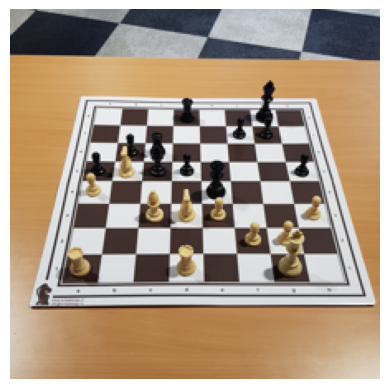

In [26]:
for batch in train_dataloader:
    # Get images of the batch and print their dimensions
    imgs = batch[0]
    imgs = imgs.permute(0, 2, 3, 1)*torch.tensor([[[0.229, 0.224, 0.225]]]) + torch.tensor([[[0.485, 0.456, 0.406]]])
    print(imgs.shape)

    # Get labels of each image in the batch and print them
    labels = batch[1]
    print(labels.shape)
    print(labels[0])

    # Show first image of the batch
    plt.imshow(imgs[0])
    plt.axis('off')
    plt.show()

    break

## Defining the model

We will use a pre-trained ResNet50 network.

In [78]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
model1 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# change the number of neurons in the last layer to the number of classes of the problem at hand (maximum number of pieces on a chess game)
num_classes = 32
model1.fc = nn.Linear(model1.fc.in_features, 32)

model1.to(device)

Using cpu device


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Train the model

Define function to perform one iteration

In [82]:
from tqdm import tqdm
def train_classifier(model, train_dataloader, val_dataloader, loss_fn, optimizer, device, num_epochs=50, lr_scheduler=None):
    
    model = model.to(device)
    
    # Evaluation history
    train_history = {
        'loss': [],
        'acc': [],
    }
    val_history = {
        'loss': [],
        'acc': [],
    }
    for epoch in range(num_epochs):
        # Training 
        model.train()
        epoch_train_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]"):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels.argmax(dim=1))
            loss.backward()
            optimizer.step()
            
            epoch_train_loss += loss.item()
            _, predicted = outputs.max(1)
            _, labels_idx = labels.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels_idx).sum().item()
        
        train_loss = epoch_train_loss / len(train_dataloader)
        train_acc = 100. * correct / total
        train_history['loss'].append(train_loss)
        train_history['acc'].append(train_acc)
        
        # Validation 
        val_loss, val_acc = evaluate_classifier(model, val_dataloader, loss_fn, device)
        val_history['loss'].append(val_loss)
        val_history['acc'].append(val_acc)
        
        # # Update learning rate if scheduler provided
        # if lr_scheduler:
        #     if isinstance(lr_scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
        #         lr_scheduler.step(val_loss)
        #     else:
        #         lr_scheduler.step()
        
        print(f'Train Loss: {train_loss:.4f} || Train Acc: {train_acc:.2f}')
        print(f'Val Loss: {val_loss:.4f} || Val Acc: {val_acc:.2f}')
    
    return train_history, val_history

def evaluate_classifier(model, dataloader, loss_fn, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in dataloader:

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            loss = loss_fn(outputs, labels.argmax(dim=1))
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            _, labels_idx = labels.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels_idx).sum().item()
    
    loss = running_loss / len(dataloader)
    acc = 100. * correct / total
    return loss, acc

Define loss, optimizer and train the model

In [80]:
import torch.optim as optim

# Define loss function
loss_fn = nn.CrossEntropyLoss()

# Define optimizer
optimizer_phase1 = optim.Adam(model1.fc.parameters(), lr=0.001)
optimizer_phase2 = optim.Adam(model1.fc.parameters(), lr=0.0001)

## Analyse training evolution

In [ ]:
# 1 Phase: train with frozen layers
for name, param in model1.named_parameters():
    if not name.startswith('fc'):
        param.requires_grad = False

train_history_phase1, val_history_phase1 = train_classifier(
    model1, train_dataloader, valid_dataloader, loss_fn, optimizer_phase1, device, num_epochs=10
)

In [ ]:
# 2nd Phase: train whole model (unfreeze)
for param in model1.parameters():
    param.requires_grad = True
    
train_history_phase2, val_history_phase2 = train_classifier(
    model1, train_dataloader, valid_dataloader, loss_fn, optimizer_phase2, device, num_epochs=40
)

Plot loss and accuracy throughout training on train and validation data

In [ ]:
train_history = train_history_phase1.extend(train_history_phase2)
val_history = val_history_phase1.extend(val_history_phase2)

In [93]:
def plotTrainingHistory(train_history, val_history):
    plt.subplot(2, 1, 1)
    plt.title('Cross Entropy Loss')
    plt.plot(train_history['loss'], label='train')
    plt.plot(val_history['loss'], label='val')
    plt.legend(loc='best')

    plt.subplot(2, 1, 2)
    plt.title('Classification Accuracy')
    plt.plot(train_history['accuracy'], label='train')
    plt.plot(val_history['accuracy'], label='val')

    plt.tight_layout()
    plt.legend(loc='best')
    plt.show()

In [ ]:
plotTrainingHistory(train_history, val_history)

## Test the model

Evaluate the model in the test set

In [2]:
# Load the best model

# Evaluate model on test data
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

def test_classifier(model, test_dataloader, device):
    model.eval()
    model.to(device)
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            _, labels_idx = labels.max(1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels_idx.cpu().numpy())
    
    # Metrics
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    cm = confusion_matrix(all_labels, all_preds)
    
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test F1 Score (weighted): {f1:.4f}")
    print("\nConfusion Matrix:")
    print(cm)
    
    return {
        'accuracy': accuracy,
        'f1_score': f1,
        'confusion_matrix': cm,
        'predictions': all_preds,
        'true_labels': all_labels
    }
test_results = test_classifier(model1, test_dataloader, device)

In [ ]:
test_results = test_classifier(model1, test_dataloader, device)

## Challenge

In transfer learning, we often replace the head of the model (fully-connected layers responsible for classification) to fit the task. However, these new layers are not pre-trained and thus they contain an error that is backpropagated through the pre-trained part of the network during training. We can avoid this through a training strategy that is divided into two steps:
* Freeze the pre-trained layers of the network so that their parameters are no longer updated during training and train only the head of the model
* Unfreeze these layers and train the network as a whole.

Implement this strategy and see the results!

## For Group Project - Task 2: Adapt multiclass classification network to regression!

Now that you have a multiclass baseline, adapt the network for the regression problem, considering the following aspects:
* How many neurons should the last layer of a regression network have?
* What should be the final activation function for a regression network?
* What loss functions can be used to train a regression network?

# REGRESSION MODEL: START HERE

In [ ]:
from torchvision.transforms import InterpolationMode
# Normalize images
data_aug = transforms.Compose([
    transforms.ToImage(),
    transforms.Resize((256, 256), interpolation=InterpolationMode.BICUBIC),
    transforms.CenterCrop((224, 224)),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_in = transforms.Compose([
    transforms.ToImage(),
    transforms.Resize((256, 256), interpolation=InterpolationMode.BICUBIC),
    transforms.CenterCrop((224, 224)),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [134]:
def chesspos2number(chesspos):
    col = ord(chesspos[0])-ord('a')
    row = int(chesspos[1])-1
    return row, col

class ChessDataset(Dataset):
    def __init__(self, root_dir, partition, transform=None):
        self.anns = json.load(open(os.path.join(root_dir, 'annotations.json')))
        self.categories = [c['name'] for c in self.anns['categories']]
        self.root = root_dir
        self.ids = []
        self.file_names = []
        for x in self.anns['images']:
            self.file_names.append(x['path'])
            self.ids.append(x['id'])
        self.file_names = np.asarray(self.file_names)
        self.ids = np.asarray(self.ids)
        self.boards = torch.zeros((len(self.file_names), 8, 8))
        for piece in self.anns['annotations']['pieces']:
            idx = np.where(self.ids == piece['image_id'])[0][0]
            row, col = chesspos2number(piece['chessboard_position'])
            self.boards[idx][row][col] = 1

        if partition == 'train':
            self.split_ids = np.asarray(self.anns['splits']['chessred2k']['train']['image_ids']).astype(int)
        elif partition == 'valid':
            self.split_ids = np.asarray(self.anns['splits']['chessred2k']['val']['image_ids']).astype(int)
        else:
            self.split_ids = np.asarray(self.anns['splits']['chessred2k']['test']['image_ids']).astype(int)

        intersect = np.isin(self.ids, self.split_ids)
        self.split_ids = np.where(intersect)[0]
        self.file_names = self.file_names[self.split_ids]
        self.boards = self.boards[self.split_ids]
        self.num_pieces = torch.sum(self.boards.view(len(self.boards), 64), axis=-1)
        self.ids = self.ids[self.split_ids]

        self.transform = transform
        print(f"Number of {partition} images: {len(self.file_names)}")

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, i):
        image = cv2.imread(os.path.join(self.root, self.file_names[i]))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            image = self.transform(image)

        num_pieces = self.num_pieces[i].item()

        return image, num_pieces

train_dataset = ChessDataset('', 'train', data_aug)
valid_dataset = ChessDataset('', 'valid', data_in)
test_dataset = ChessDataset('', 'test', data_in)

Number of train images: 1442
Number of valid images: 330
Number of test images: 306


In [136]:
# get cpu or gpu device for training
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# now we need to define a Dataloader, which allows us to automatically batch our inputs, do sampling and multiprocess data loading
batch_size = 16

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

Using cpu device


In [27]:
# Regression mdoel
model2 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# Change the last layer for regression (single output neuron)
model2.fc = nn.Linear(model2.fc.in_features, 1)

model2.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [28]:
def train_regressor(model, train_dataloader, val_dataloader, loss_fn, optimizer, device, num_epochs=50, lr_scheduler=None):
    
    model = model.to(device)
    
    # Evaluation history
    train_history = {
        'loss': [],
        'mae': [],
    }
    val_history = {
        'loss': [],
        'mae': [],
    }
    
    for epoch in range(num_epochs):
        # Training 
        model.train()
        epoch_train_loss = 0.0
        epoch_train_mae = 0.0
        
        for inputs, labels in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]"):
            inputs = inputs.to(device)
            labels = labels.to(device).float()
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()
            
            epoch_train_loss += loss.item()
            epoch_train_mae += torch.nn.functional.l1_loss(outputs.squeeze(), labels).item()
        
        train_loss = epoch_train_loss / len(train_dataloader)
        train_mae = epoch_train_mae / len(train_dataloader)
        train_history['loss'].append(train_loss)
        train_history['mae'].append(train_mae)
        
        # Validation 
        val_loss, val_mae = evaluate_regressor(model, val_dataloader, loss_fn, device)
        val_history['loss'].append(val_loss)
        val_history['mae'].append(val_mae)
        
        print(f'Train Loss: {train_loss:.4f} || Train MAE: {train_mae:.4f}')
        print(f'Val Loss: {val_loss:.4f} || Val MAE: {val_mae:.4f}')
    
    return train_history, val_history

def evaluate_regressor(model, dataloader, loss_fn, device):
    model.eval()
    running_loss = 0.0
    running_mae = 0.0
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device).float()  # Ensure labels are float for regression
            
            outputs = model(inputs)
            loss = loss_fn(outputs.squeeze(), labels)
            
            running_loss += loss.item()
            running_mae += torch.nn.functional.l1_loss(outputs.squeeze(), labels).item()
    
    loss = running_loss / len(dataloader)
    mae = running_mae / len(dataloader)
    return loss, mae

In [31]:
import torch.optim as optim
# Loss Function
loss_fn_r = nn.MSELoss()

# Optimizer
optimizer_phase1 = optim.Adam(model2.fc.parameters(), lr=0.001)
optimizer_phase2 = optim.Adam(model2.parameters(), lr=0.0001)

In [32]:
# Phase 1: train with frozen params
for name, param in model2.named_parameters():
    if not name.startswith('fc'):
        param.requires_grad = False

train_history_r_phase1, val_history_r_phase1 = train_regressor(
    model2, train_dataloader, valid_dataloader, loss_fn_r, optimizer_phase1, device, num_epochs=10
)

Epoch 1/10 [Training]: 100%|████████████████████| 90/90 [07:05<00:00,  4.73s/it]


Train Loss: 141.8836 || Train MAE: 9.6627
Val Loss: 88.9520 || Val MAE: 8.1997


Epoch 2/10 [Training]: 100%|████████████████████| 90/90 [06:36<00:00,  4.41s/it]


Train Loss: 55.0459 || Train MAE: 6.3944
Val Loss: 79.1545 || Val MAE: 7.7668


Epoch 3/10 [Training]: 100%|████████████████████| 90/90 [06:32<00:00,  4.36s/it]


Train Loss: 51.1164 || Train MAE: 6.1619
Val Loss: 73.2633 || Val MAE: 7.4713


Epoch 4/10 [Training]: 100%|████████████████████| 90/90 [06:36<00:00,  4.41s/it]


Train Loss: 46.4184 || Train MAE: 5.8865
Val Loss: 72.4903 || Val MAE: 7.3623


Epoch 5/10 [Training]: 100%|████████████████████| 90/90 [06:49<00:00,  4.55s/it]


Train Loss: 42.1545 || Train MAE: 5.5892
Val Loss: 64.4474 || Val MAE: 6.9665


Epoch 6/10 [Training]: 100%|████████████████████| 90/90 [06:07<00:00,  4.08s/it]


Train Loss: 37.7181 || Train MAE: 5.2666
Val Loss: 56.0134 || Val MAE: 6.5072


Epoch 7/10 [Training]: 100%|████████████████████| 90/90 [06:24<00:00,  4.28s/it]


Train Loss: 34.5703 || Train MAE: 5.0069
Val Loss: 51.6492 || Val MAE: 6.2292


Epoch 8/10 [Training]: 100%|████████████████████| 90/90 [05:52<00:00,  3.91s/it]


Train Loss: 31.3427 || Train MAE: 4.7532
Val Loss: 47.5629 || Val MAE: 5.9519


Epoch 9/10 [Training]: 100%|████████████████████| 90/90 [07:04<00:00,  4.71s/it]


Train Loss: 28.5034 || Train MAE: 4.5031
Val Loss: 42.6544 || Val MAE: 5.6434


Epoch 10/10 [Training]: 100%|███████████████████| 90/90 [06:52<00:00,  4.58s/it]


Train Loss: 27.5552 || Train MAE: 4.4101
Val Loss: 42.0445 || Val MAE: 5.5221


In [36]:
# 2nd Phase: train whole model (unfreeze)
for param in model2.parameters():
    param.requires_grad = True
    
train_history_r_phase2, val_history_r_phase2 = train_regressor(
    model2, train_dataloader, valid_dataloader, loss_fn_r, optimizer_phase2, device, num_epochs=40
)

Epoch 1/40 [Training]: 100%|████████████████████| 90/90 [09:40<00:00,  6.45s/it]


Train Loss: 11.6404 || Train MAE: 2.6756
Val Loss: 5.6470 || Val MAE: 1.8460


Epoch 2/40 [Training]: 100%|████████████████████| 90/90 [10:07<00:00,  6.75s/it]


Train Loss: 6.2584 || Train MAE: 1.9904
Val Loss: 4.4333 || Val MAE: 1.7631


Epoch 3/40 [Training]: 100%|████████████████████| 90/90 [11:32<00:00,  7.70s/it]


Train Loss: 4.2232 || Train MAE: 1.6424
Val Loss: 4.1321 || Val MAE: 1.6758


Epoch 4/40 [Training]: 100%|████████████████████| 90/90 [11:08<00:00,  7.43s/it]


Train Loss: 3.3423 || Train MAE: 1.4503
Val Loss: 3.6933 || Val MAE: 1.5982


Epoch 5/40 [Training]: 100%|████████████████████| 90/90 [17:52<00:00, 11.92s/it]


Train Loss: 3.7251 || Train MAE: 1.5310
Val Loss: 3.0202 || Val MAE: 1.4390


Epoch 6/40 [Training]: 100%|████████████████████| 90/90 [16:04<00:00, 10.72s/it]


Train Loss: 3.6966 || Train MAE: 1.5551
Val Loss: 4.5785 || Val MAE: 1.8134


Epoch 7/40 [Training]: 100%|████████████████████| 90/90 [13:58<00:00,  9.32s/it]


Train Loss: 3.7651 || Train MAE: 1.5380
Val Loss: 3.9913 || Val MAE: 1.6078


Epoch 8/40 [Training]: 100%|████████████████████| 90/90 [09:30<00:00,  6.34s/it]


Train Loss: 2.6460 || Train MAE: 1.2822
Val Loss: 3.3637 || Val MAE: 1.5235


Epoch 9/40 [Training]: 100%|████████████████████| 90/90 [09:28<00:00,  6.32s/it]


Train Loss: 2.8335 || Train MAE: 1.3537
Val Loss: 4.2373 || Val MAE: 1.7728


Epoch 10/40 [Training]:   4%|▉                   | 4/90 [00:29<10:26,  7.29s/it]


KeyboardInterrupt: 

## - Training Optimization bc of the overfitting in the previous model

In [73]:
# Training Optimization

# Regression model
model3 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# Change the last layer for regression (single output neuron)
model3.fc = nn.Linear(model3.fc.in_features, 1)

model3.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [74]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
import copy

def train_regressor(model, train_dataloader, val_dataloader, loss_fn, optimizer, device, 
                   num_epochs, lr_scheduler=None, early_stopping_patience=5):
    
    model = model.to(device)
    best_val_mae = float('inf')
    epochs_no_improve = 0
    best_model_weights = None
    
    train_history = {'loss': [], 'mae': []}
    val_history = {'loss': [], 'mae': []}

    for epoch in range(num_epochs):
        # Training
        model.train()
        epoch_train_loss = 0.0
        epoch_train_mae = 0.0
        
        for inputs, labels in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]"):
            inputs = inputs.to(device)
            labels = labels.to(device).float()
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs.squeeze(), labels)
            loss.backward()
            
            optimizer.step()
            
            epoch_train_loss += loss.item()
            epoch_train_mae += torch.nn.functional.l1_loss(outputs.squeeze(), labels).item()
        
        # Val
        val_loss, val_mae = evaluate_regressor(model, val_dataloader, loss_fn, device)
        
        # LR Scheduling
        if lr_scheduler:
            if isinstance(lr_scheduler, ReduceLROnPlateau):
                lr_scheduler.step(val_loss)
            else:
                lr_scheduler.step()
        
        # Early Stopping
        if val_mae < best_val_mae:
            best_val_mae = val_mae
            epochs_no_improve = 0
            best_model_weights = copy.deepcopy(model.state_dict())
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= early_stopping_patience:
                print(f'\nEarly stopping at epoch {epoch+1}')
                model.load_state_dict(best_model_weights)
                break
        
        # History 
        train_history['loss'].append(epoch_train_loss / len(train_dataloader))
        train_history['mae'].append(epoch_train_mae / len(train_dataloader))
        val_history['loss'].append(val_loss)
        val_history['mae'].append(val_mae)
        
        print(f'\nTrain Loss: {train_history["loss"][-1]:.4f} | Train MAE: {train_history["mae"][-1]:.4f}')
        print(f'Val Loss: {val_loss:.4f} | Val MAE: {val_mae:.4f}')
        print(f'Best Val MAE: {best_val_mae:.4f} | LR: {optimizer.param_groups[0]["lr"]:.2e}')
    
    return train_history, val_history

In [81]:
# Loss Function
loss_fn_r = nn.MSELoss()

# Optimizers
optimizer_phase1 = optim.Adam(model3.fc.parameters(), lr=0.001)
optimizer_phase2 = optim.Adam(model3.parameters(), lr=0.0001)

# Schedulers
scheduler_phase1 = ReduceLROnPlateau(optimizer_phase1, 'min', patience=2)
scheduler_phase2 = ReduceLROnPlateau(optimizer_phase2, 'min', patience=3, factor=0.5)

In [83]:
# Phase 1: training with frozen params
for name, param in model3.named_parameters():
    if not name.startswith('fc'):
        param.requires_grad = False

train_history_r_phase1, val_history_r_phase1 = train_regressor(
    model3, train_dataloader, valid_dataloader, loss_fn_r, optimizer_phase1,
    device, num_epochs=10, lr_scheduler=scheduler_phase1, early_stopping_patience=3
)

Epoch 1/10 [Training]: 100%|████████████████████| 90/90 [05:33<00:00,  3.71s/it]



Train Loss: 140.0362 | Train MAE: 9.5117
Val Loss: 90.0293 | Val MAE: 8.2351
Best Val MAE: 8.2351 | LR: 1.00e-03


Epoch 2/10 [Training]: 100%|████████████████████| 90/90 [05:33<00:00,  3.70s/it]



Train Loss: 54.8684 | Train MAE: 6.4370
Val Loss: 80.8394 | Val MAE: 7.8333
Best Val MAE: 7.8333 | LR: 1.00e-03


Epoch 3/10 [Training]: 100%|████████████████████| 90/90 [05:29<00:00,  3.66s/it]



Train Loss: 51.8027 | Train MAE: 6.2221
Val Loss: 73.4802 | Val MAE: 7.4649
Best Val MAE: 7.4649 | LR: 1.00e-03


Epoch 4/10 [Training]: 100%|████████████████████| 90/90 [05:31<00:00,  3.69s/it]



Train Loss: 46.5754 | Train MAE: 5.8993
Val Loss: 66.8087 | Val MAE: 7.1133
Best Val MAE: 7.1133 | LR: 1.00e-03


Epoch 5/10 [Training]: 100%|████████████████████| 90/90 [05:32<00:00,  3.70s/it]



Train Loss: 42.3453 | Train MAE: 5.5958
Val Loss: 64.6875 | Val MAE: 6.9545
Best Val MAE: 6.9545 | LR: 1.00e-03


Epoch 6/10 [Training]: 100%|████████████████████| 90/90 [06:10<00:00,  4.11s/it]



Train Loss: 38.2547 | Train MAE: 5.3052
Val Loss: 55.5278 | Val MAE: 6.4696
Best Val MAE: 6.4696 | LR: 1.00e-03


Epoch 7/10 [Training]: 100%|████████████████████| 90/90 [06:28<00:00,  4.32s/it]



Train Loss: 34.3460 | Train MAE: 4.9881
Val Loss: 49.7963 | Val MAE: 6.1263
Best Val MAE: 6.1263 | LR: 1.00e-03


Epoch 8/10 [Training]: 100%|████████████████████| 90/90 [05:46<00:00,  3.85s/it]



Train Loss: 32.1662 | Train MAE: 4.8244
Val Loss: 44.4577 | Val MAE: 5.7802
Best Val MAE: 5.7802 | LR: 1.00e-03


Epoch 9/10 [Training]: 100%|████████████████████| 90/90 [05:55<00:00,  3.95s/it]



Train Loss: 30.1602 | Train MAE: 4.6367
Val Loss: 43.2520 | Val MAE: 5.6464
Best Val MAE: 5.6464 | LR: 1.00e-03


Epoch 10/10 [Training]: 100%|███████████████████| 90/90 [05:53<00:00,  3.93s/it]



Train Loss: 26.8310 | Train MAE: 4.3510
Val Loss: 40.4837 | Val MAE: 5.4458
Best Val MAE: 5.4458 | LR: 1.00e-03


In [85]:
# 2nd Phase: training entire model (unfreeze)
for param in model3.parameters():
    param.requires_grad = True

train_history_r_phase2, val_history_r_phase2 = train_regressor(
    model3, train_dataloader, valid_dataloader, loss_fn_r, optimizer_phase2,
    device, num_epochs=40, lr_scheduler=scheduler_phase2, early_stopping_patience=5
)

Epoch 1/40 [Training]: 100%|████████████████████| 90/90 [08:30<00:00,  5.67s/it]



Train Loss: 10.6206 | Train MAE: 2.5371
Val Loss: 8.1473 | Val MAE: 2.4091
Best Val MAE: 2.4091 | LR: 1.00e-04


Epoch 2/40 [Training]: 100%|████████████████████| 90/90 [08:20<00:00,  5.56s/it]



Train Loss: 6.3385 | Train MAE: 2.0018
Val Loss: 5.9162 | Val MAE: 1.9829
Best Val MAE: 1.9829 | LR: 1.00e-04


Epoch 3/40 [Training]: 100%|████████████████████| 90/90 [08:19<00:00,  5.55s/it]



Train Loss: 4.0011 | Train MAE: 1.6008
Val Loss: 3.3868 | Val MAE: 1.5056
Best Val MAE: 1.5056 | LR: 1.00e-04


Epoch 4/40 [Training]: 100%|████████████████████| 90/90 [08:20<00:00,  5.56s/it]



Train Loss: 3.9765 | Train MAE: 1.5940
Val Loss: 3.6774 | Val MAE: 1.5498
Best Val MAE: 1.5056 | LR: 1.00e-04


Epoch 5/40 [Training]: 100%|████████████████████| 90/90 [08:23<00:00,  5.59s/it]



Train Loss: 3.7670 | Train MAE: 1.5329
Val Loss: 3.3083 | Val MAE: 1.4844
Best Val MAE: 1.4844 | LR: 1.00e-04


Epoch 6/40 [Training]: 100%|████████████████████| 90/90 [08:23<00:00,  5.60s/it]



Train Loss: 3.8598 | Train MAE: 1.5752
Val Loss: 3.5745 | Val MAE: 1.5095
Best Val MAE: 1.4844 | LR: 1.00e-04


Epoch 7/40 [Training]: 100%|████████████████████| 90/90 [09:26<00:00,  6.30s/it]



Train Loss: 2.7312 | Train MAE: 1.2980
Val Loss: 3.3883 | Val MAE: 1.4725
Best Val MAE: 1.4725 | LR: 1.00e-04


Epoch 8/40 [Training]: 100%|████████████████████| 90/90 [09:30<00:00,  6.34s/it]



Train Loss: 2.5441 | Train MAE: 1.2516
Val Loss: 4.5114 | Val MAE: 1.7398
Best Val MAE: 1.4725 | LR: 1.00e-04


Epoch 9/40 [Training]: 100%|████████████████████| 90/90 [09:42<00:00,  6.47s/it]



Train Loss: 2.0950 | Train MAE: 1.1553
Val Loss: 4.4974 | Val MAE: 1.8461
Best Val MAE: 1.4725 | LR: 5.00e-05


Epoch 10/40 [Training]: 100%|███████████████████| 90/90 [09:56<00:00,  6.62s/it]



Train Loss: 2.0746 | Train MAE: 1.1215
Val Loss: 2.0261 | Val MAE: 1.1560
Best Val MAE: 1.1560 | LR: 5.00e-05


Epoch 11/40 [Training]: 100%|███████████████████| 90/90 [09:59<00:00,  6.66s/it]



Train Loss: 1.8304 | Train MAE: 1.0497
Val Loss: 3.1378 | Val MAE: 1.4762
Best Val MAE: 1.1560 | LR: 5.00e-05


Epoch 12/40 [Training]: 100%|███████████████████| 90/90 [10:04<00:00,  6.72s/it]



Train Loss: 1.3525 | Train MAE: 0.8986
Val Loss: 2.4778 | Val MAE: 1.2933
Best Val MAE: 1.1560 | LR: 5.00e-05


Epoch 13/40 [Training]: 100%|███████████████████| 90/90 [10:01<00:00,  6.68s/it]



Train Loss: 1.7045 | Train MAE: 1.0001
Val Loss: 3.0453 | Val MAE: 1.4750
Best Val MAE: 1.1560 | LR: 5.00e-05


Epoch 14/40 [Training]: 100%|███████████████████| 90/90 [10:05<00:00,  6.73s/it]



Train Loss: 0.9173 | Train MAE: 0.7712
Val Loss: 2.3064 | Val MAE: 1.2214
Best Val MAE: 1.1560 | LR: 2.50e-05


Epoch 15/40 [Training]: 100%|███████████████████| 90/90 [10:06<00:00,  6.74s/it]



Train Loss: 1.3041 | Train MAE: 0.8032
Val Loss: 2.0356 | Val MAE: 1.1196
Best Val MAE: 1.1196 | LR: 2.50e-05


Epoch 16/40 [Training]: 100%|███████████████████| 90/90 [10:06<00:00,  6.73s/it]



Train Loss: 0.9387 | Train MAE: 0.7536
Val Loss: 3.1551 | Val MAE: 1.4911
Best Val MAE: 1.1196 | LR: 2.50e-05


Epoch 17/40 [Training]: 100%|███████████████████| 90/90 [10:07<00:00,  6.75s/it]



Train Loss: 1.0020 | Train MAE: 0.7998
Val Loss: 2.1538 | Val MAE: 1.2104
Best Val MAE: 1.1196 | LR: 2.50e-05


Epoch 18/40 [Training]: 100%|███████████████████| 90/90 [10:07<00:00,  6.75s/it]



Train Loss: 0.7525 | Train MAE: 0.6852
Val Loss: 2.4473 | Val MAE: 1.2856
Best Val MAE: 1.1196 | LR: 1.25e-05


Epoch 19/40 [Training]: 100%|███████████████████| 90/90 [10:08<00:00,  6.76s/it]



Train Loss: 0.5880 | Train MAE: 0.6113
Val Loss: 2.1851 | Val MAE: 1.2027
Best Val MAE: 1.1196 | LR: 1.25e-05


Epoch 20/40 [Training]: 100%|███████████████████| 90/90 [10:12<00:00,  6.81s/it]



Early stopping at epoch 20


In [91]:
# Merge training and val loss, mae from both phases
train_history_r = {
    'loss': train_history_r_phase1['loss'] + train_history_r_phase2['loss'],
    'mae': train_history_r_phase1['mae'] + train_history_r_phase2['mae']
}
val_history_r ={ 
    'loss': val_history_r_phase1['loss'] + val_history_r_phase2['loss'],
    'mae': val_history_r_phase1['mae'] + val_history_r_phase2['mae']
}

In [119]:
def plotTrainingHistoryReg(train_history, val_history):
    plt.figure(figsize=(10, 8))
    
    # MSE Loss plot
    plt.subplot(2, 1, 1)
    plt.plot(train_history['loss'], label='Train', linewidth=2)
    plt.plot(val_history['loss'], label='Validation', linewidth=2)
    plt.title('MSE Loss', fontsize=14, pad=20)
    plt.ylabel('Loss', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=12)
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # MAE plot
    plt.subplot(2, 1, 2)
    plt.plot(train_history['mae'], label='Train', linewidth=2)
    plt.plot(val_history['mae'], label='Validation', linewidth=2)
    plt.title('MAE', fontsize=14, pad=20)
    plt.ylabel('MAE', fontsize=12)
    plt.xlabel('Epoch', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=12)
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.tight_layout()
    plt.show()

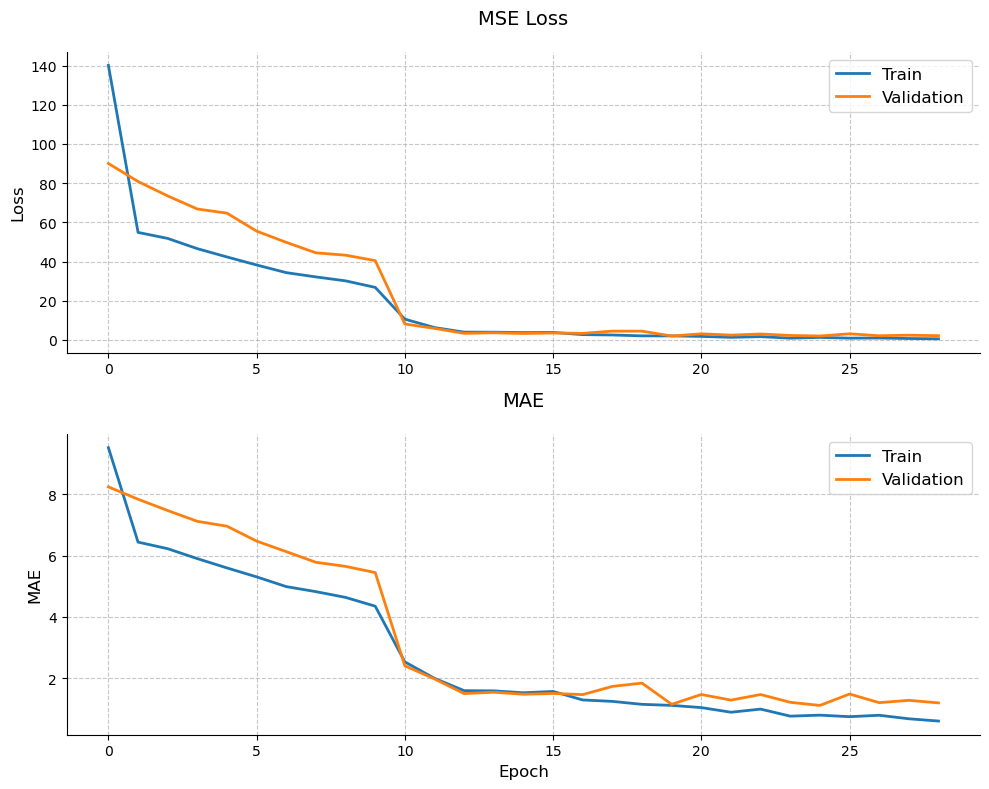

In [120]:
# Plot training and validation process
plotTrainingHistoryReg(train_history_r, val_history_r)

In [97]:
# Test Evaluation
def test_regressor(model, test_dataloader, device):
    model.eval()
    predictions = []
    true_values = []
    
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device).float()
            
            outputs = model(inputs)
            
            predictions.extend(outputs.cpu().numpy().flatten())
            true_values.extend(labels.cpu().numpy().flatten())
    
    return np.array(predictions), np.array(true_values)

predictions, true_values = test_regressor(model3, test_dataloader, device)

In [124]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

rounded_predictions = np.round(predictions) # rounded predcitons because number of pieces -> integers

mae = mean_absolute_error(true_values, rounded_predictions)
mse = mean_squared_error(true_values, rounded_predictions)
rmse = np.sqrt(mse)
r2 = r2_score(true_values, rounded_predictions)

print(f"\n**Test Metrics**\n")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")


**Test Metrics**

MAE: 1.0817
MSE: 2.0229
RMSE: 1.4223
R²: 0.9706


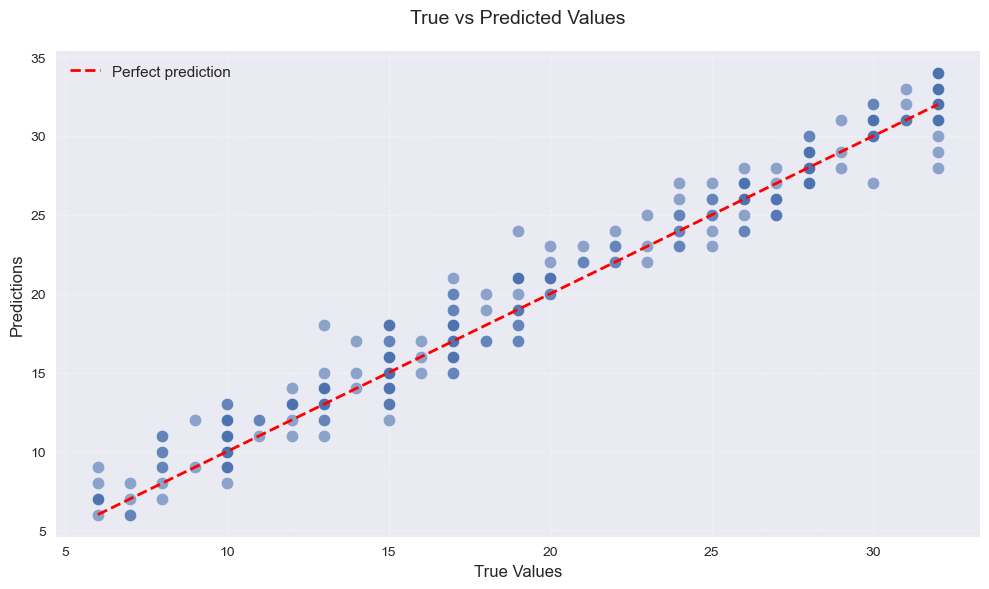

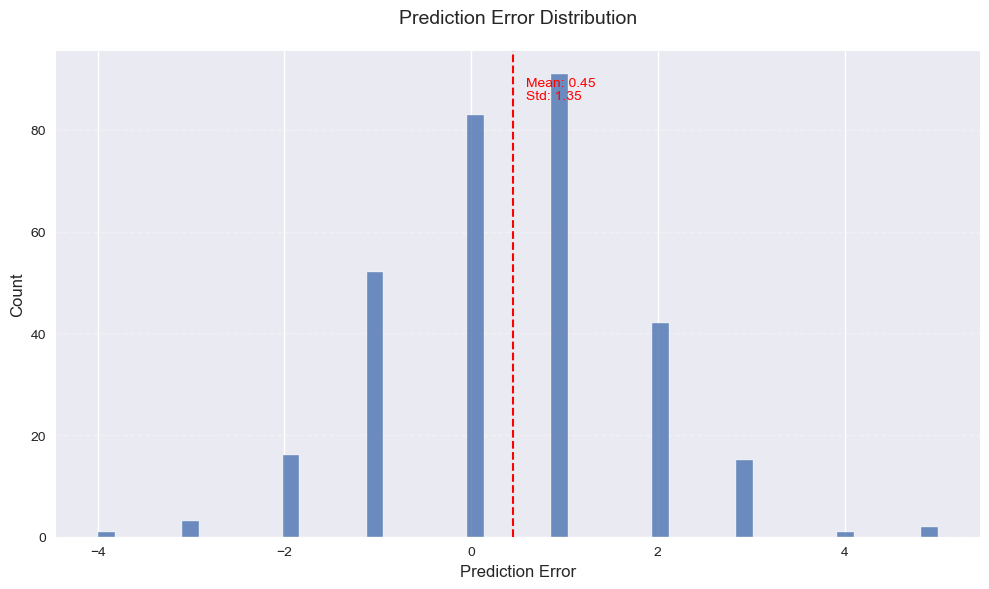

In [127]:
import matplotlib.pyplot as plt
import numpy as np

# Set style
plt.style.use('seaborn-v0_8')

# True vs Predicted plot
plt.figure(figsize=(10, 6))
plt.scatter(true_values, rounded_predictions, 
            alpha=0.6,
            edgecolor='w',
            linewidth=0.5,
            s=80)
plt.plot([np.min(true_values), np.max(true_values)], 
         [np.min(true_values), np.max(true_values)], 
         'r--', 
         linewidth=2,
         label='Perfect prediction')
plt.xlabel('True Values', fontsize=12)
plt.ylabel('Predictions', fontsize=12)
plt.title('True vs Predicted Values', fontsize=14, pad=20)
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(fontsize=11)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

# Errors Histogram
errors = rounded_predictions - true_values
plt.figure(figsize=(10, 6))
plt.hist(errors, 
         bins=50, 
         edgecolor='white',
         alpha=0.8)
plt.xlabel('Prediction Error', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Prediction Error Distribution', fontsize=14, pad=20)
plt.grid(True, axis='y', linestyle='--', alpha=0.3)
mean_err = np.mean(errors)
std_err = np.std(errors)
plt.axvline(mean_err, color='r', linestyle='--', linewidth=1.5)
plt.text(mean_err + 0.1*std_err, plt.ylim()[1]*0.9, 
         f'Mean: {mean_err:.2f}\nStd: {std_err:.2f}',
         color='red')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

In [128]:
# Save model
torch.save(model3, 'model3.pth')

## Classification - pipline board detector, squares separation and binary classification: occupied or not (then sum it)

In [3]:
def chesspos2number(chesspos):
    col = ord(chesspos[0]) - ord('a') 
    row = 8 - int(chesspos[1]) 
    return row, col

class ChessDataset(Dataset):
    def __init__(self, root_dir, partition, transform=None):
        self.anns = json.load(open(os.path.join(root_dir, 'annotations.json')))
        self.categories = [c['name'] for c in self.anns['categories']]
        self.root = root_dir
        self.ids = []
        self.file_names = []
        for x in self.anns['images']:
            self.file_names.append(x['path'])
            self.ids.append(x['id'])
        self.file_names = np.asarray(self.file_names)
        self.ids = np.asarray(self.ids)
        
        # Inicjalizacja szachownicy 8x8 z zerami (brak figur)
        self.boards = torch.zeros((len(self.file_names), 8, 8), dtype=torch.float32)
        
        # Wypełnij miejsca, gdzie są figury (1 = figura istnieje)
        for piece in self.anns['annotations']['pieces']:
            idx = np.where(self.ids == piece['image_id'])[0][0]
            row, col = chesspos2number(piece['chessboard_position'])
            self.boards[idx][row][col] = 1  # Oznacz obecność figury

        if partition == 'train':
            self.split_ids = np.asarray(self.anns['splits']['chessred2k']['train']['image_ids']).astype(int)
        elif partition == 'valid':
            self.split_ids = np.asarray(self.anns['splits']['chessred2k']['val']['image_ids']).astype(int)
        else:
            self.split_ids = np.asarray(self.anns['splits']['chessred2k']['test']['image_ids']).astype(int)

        intersect = np.isin(self.ids, self.split_ids)
        self.split_ids = np.where(intersect)[0]
        self.file_names = self.file_names[self.split_ids]
        self.boards = self.boards[self.split_ids]
        self.ids = self.ids[self.split_ids]

        self.transform = transform
        print(f"Number of {partition} images: {len(self.file_names)}")

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, i):
        image = cv2.imread(os.path.join(self.root, self.file_names[i]))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            image = self.transform(image)

        board = self.boards[i]

        return image, board
        
train_dataset = ChessDataset('', 'train', data_aug)
valid_dataset = ChessDataset('', 'valid', data_in)
test_dataset = ChessDataset('', 'test', data_in)

Number of train images: 1442
Number of valid images: 330
Number of test images: 306


In [4]:
# get cpu or gpu device for training
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# now we need to define a Dataloader, which allows us to automatically batch our inputs, do sampling and multiprocess data loading
batch_size = 16

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

Using cpu device


In [5]:
train_dataset[1]

(Image([[[ 1.4440,  1.4098,  1.3927,  ..., -0.0629, -0.0801, -0.0801],
         [ 1.2728,  1.2728,  1.3070,  ..., -0.0629, -0.0629, -0.0801],
         [ 1.2728,  1.2557,  1.2899,  ..., -0.0801, -0.0801, -0.0801],
         ...,
         [ 1.8379,  1.7352,  1.7523,  ...,  1.2385,  1.1529,  1.0159],
         [ 1.9235,  1.7694,  1.7523,  ...,  1.2728,  1.2385,  1.1187],
         [ 1.8893,  1.7180,  1.6838,  ...,  1.1015,  1.2385,  1.2043]],
 
        [[ 0.8004,  0.7654,  0.7479,  ...,  0.1001,  0.0826,  0.0826],
         [ 0.6429,  0.6429,  0.6779,  ...,  0.1001,  0.1001,  0.0826],
         [ 0.6429,  0.6254,  0.6604,  ...,  0.0826,  0.0826,  0.0826],
         ...,
         [ 1.5882,  1.4657,  1.5007,  ...,  0.6604,  0.5728,  0.4328],
         [ 1.6758,  1.5007,  1.4832,  ...,  0.6954,  0.6604,  0.5378],
         [ 1.6408,  1.4657,  1.3957,  ...,  0.5203,  0.6604,  0.6254]],
 
        [[-0.1835, -0.2184, -0.2184,  ...,  0.2696,  0.2522,  0.2522],
         [-0.3230, -0.3055, -0.2881,  ..., 